# NLP Final Project Part III: Sentiment Analysis

In [1]:
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Method: Custom Classifier with Yelp Data
### Download Yelp sentiment data

In [ ]:
!gsutil -m cp -n 'gs://msca-bdp-data-open/yelp/yelp_train_sentiment.json' '/content/drive/MyDrive/Colab Notebooks/NLP_final_project/yelp_train_sentiment.json'

Skipping existing item: file:///content/drive/MyDrive/Colab Notebooks/NLP_final_project/yelp_train_sentiment.json


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/NLP_final_project/yelp_train_sentiment.json"
df= pd.read_json(path, orient='records', lines=True)

In [ ]:
df.head()

,text,label,lang
0,I love Deagan's. I do. I really do. The atmosp...,1,en
1,I love the classes at this gym. Zumba and. Rad...,1,en
2,The tables and floor were dirty. I was the onl...,0,en
3,I had an oil change at the 15515 N Scottsdale ...,0,en
4,The absolute WORST apartment complex I have ev...,0,en


In [ ]:
df.shape

(255717, 3)

In [ ]:
X = df['text']
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, train_size = 0.85, test_size = 0.15)

# Train Classifier
### SVM(Support Vector Machine）

In [ ]:
pipe_svm = make_pipeline(
    TfidfVectorizer(lowercase=False, stop_words='english', ngram_range=(1,3)),
    SGDClassifier(max_iter=100, tol=None)
)

In [ ]:
pipe_svm.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 3),
                                 stop_words='english')),
                ('sgdclassifier', SGDClassifier(max_iter=100, tol=None))])

In [ ]:
y_pred_svm = pipe_svm.predict(X_test)

In [ ]:
# calculate precision and recall
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     19199
           1       0.97      0.95      0.96     19159

    accuracy                           0.96     38358
   macro avg       0.96      0.96      0.96     38358
weighted avg       0.96      0.96      0.96     38358



### Logistic Regression

In [ ]:
pipe_logreg = make_pipeline(
    TfidfVectorizer(lowercase=False, stop_words='english', ngram_range=(1,3)),
    LogisticRegression(max_iter=1000)
)

In [ ]:
pipe_logreg.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 3),
                                 stop_words='english')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [ ]:
y_pred_logreg = pipe_logreg.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     19199
           1       0.97      0.96      0.97     19159

    accuracy                           0.97     38358
   macro avg       0.97      0.97      0.97     38358
weighted avg       0.97      0.97      0.97     38358



#### Logistic Regression has a higher accuracy and f1 score. Thus, I will apply logistic regression model to predict sentiment on the new data.

### Load cleaned AI data

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/V2_nlp_final_project_data/clean_text.csv"
df_new= pd.read_csv(path,lineterminator='\n')

In [ ]:
df_new.head()

,date,clean_title,clean_text,length
0,2017-02-07,SAP NS2’s Mark Testoni: AI Could Help Prevent ...,SAP NS2’s Mark Testoni: AI Could Help Prevent...,660
1,2019-12-31,A Decade Of Advancements As We Enter A New Age...,A Decade Of Advancements As We Enter A New Age...,1455
2,2022-03-09,Gender Bias in Artificial Intelligence | Busin...,Gender Bias in Artificial Intelligence Busine...,1253
3,2017-07-04,Big pharma turns to AI to speed drug discovery...,Big pharma turns to AI to speed drug discovery...,712
4,2018-03-13,"Amazon HQ2 Winner May Be Boston, Says Wells Fa...","Amazon HQ2 Winner May Be Boston, Says Wells Fa...",728


# Predict sentiment on new data with logistic regression classifier

In [ ]:
test = df_new['clean_title']
y_pred = pipe_logreg.predict(test)

In [ ]:
df_new["sentiment"] = y_pred

In [ ]:
df_new['sentiment_category'] = df_new['sentiment'].map({0: 'Negative', 1: 'Positive'})

In [ ]:
df_new.head()

,date,clean_title,clean_text,length,sentiment,sentiment_category
0,2017-02-07,SAP NS2’s Mark Testoni: AI Could Help Prevent ...,SAP NS2’s Mark Testoni: AI Could Help Prevent...,660,1,Positive
1,2019-12-31,A Decade Of Advancements As We Enter A New Age...,A Decade Of Advancements As We Enter A New Age...,1455,1,Positive
2,2022-03-09,Gender Bias in Artificial Intelligence | Busin...,Gender Bias in Artificial Intelligence Busine...,1253,0,Negative
3,2017-07-04,Big pharma turns to AI to speed drug discovery...,Big pharma turns to AI to speed drug discovery...,712,0,Negative
4,2018-03-13,"Amazon HQ2 Winner May Be Boston, Says Wells Fa...","Amazon HQ2 Winner May Be Boston, Says Wells Fa...",728,0,Negative


In [ ]:
# count of articles by sentiment category and date
df_sen_time = pd.DataFrame(df_new.groupby(["date", "sentiment_category"]).count()["sentiment"]).rename(columns = {"sentiment":"count_of_articles"}).reset_index()
df_sen_time.head(2)

,date,sentiment_category,count_of_articles
0,2016-08-26,Negative,1
1,2016-08-26,Positive,3


### Filter out articles with positive sentiment 

In [ ]:
df_pos = df_new[df_new["sentiment_category"]=="Positive"][["date", "clean_title", "clean_text", "sentiment", "sentiment_category"]]
df_pos.head(1)

,date,clean_title,clean_text,sentiment,sentiment_category
0,2017-02-07,SAP NS2’s Mark Testoni: AI Could Help Prevent ...,SAP NS2’s Mark Testoni: AI Could Help Prevent...,1,Positive


### Filter out articles with negative sentiment

In [ ]:
df_neg= df_new[df_new["sentiment_category"]=="Negative"][["date", "clean_title", "clean_text", "sentiment", "sentiment_category"]]
df_neg.head(1)

,date,clean_title,clean_text,sentiment,sentiment_category
2,2022-03-09,Gender Bias in Artificial Intelligence | Busin...,Gender Bias in Artificial Intelligence Busine...,0,Negative


### Export articles with positive sentiment & negative sentiment

In [ ]:
df_new.to_csv("clean_text_sent.csv", index = False)

In [ ]:
df_pos.to_csv("pos_text_custom.csv", index = False)

In [ ]:
df_neg.to_csv("neg_text_custom.csv", index = False)

In [ ]:
df_sent_count = pd.DataFrame({"Positive":len(df_pos), "Negative":len(df_neg)}.items(), columns=['sentiment', 'count_of_articles'])
df_sent_count

,sentiment,count_of_articles
0,Positive,55462
1,Negative,113335


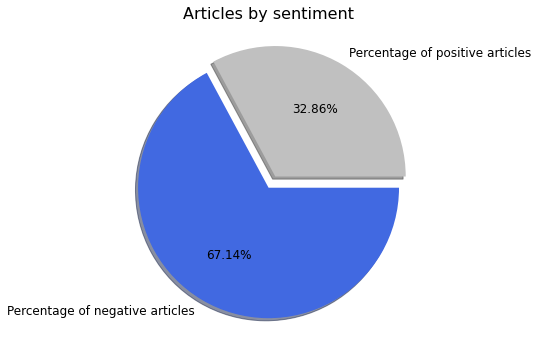

In [ ]:
# plot pie chart
title = ['Percentage of positive articles', 'Percentage of negative articles']
data = [55462, 113335]
color = ['#C0C0C0', 'royalblue']
explode = explode = (0.1, 0)
total = len(data)
textprops = {"fontsize":15}
def my_fmt(x):
    #print(x)
    return '{:.2f}%'.format(x, x)



# Creating plot
fig = plt.figure(figsize =(6, 6))
plt.pie(data, labels = title, colors = color, explode = explode, shadow = True,autopct=my_fmt,textprops = {"fontsize":12})
plt.title("Articles by sentiment", fontsize = 16)
# show plot
plt.show()

# Plot a timeline to illustrate how the sentiment is changing over time

In [3]:
path = "/content/drive/MyDrive/Colab Notebooks/V2_nlp_final_project_data/pos_text_custom.csv"
df_pos= pd.read_csv(path,lineterminator='\n')

In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/V2_nlp_final_project_data/neg_text_custom.csv"
df_neg= pd.read_csv(path,lineterminator='\n')

In [5]:
# count of articles with positive sentiment
df_count_pos = pd.DataFrame(df_pos.groupby(["date"]).count()["sentiment_category"]).rename(columns = {"sentiment_category":"count_of_positive_sentiment"})
df_count_pos.head(2)

,count_of_positive_sentiment
date,
2016-08-26,3
2016-09-18,1


In [6]:
# count of articles with negative sentiment
df_count_neg = pd.DataFrame(df_neg.groupby(["date"]).count()["sentiment_category"]).rename(columns = {"sentiment_category":"count_of_negative_sentiment"})
df_count_neg.head(2)

,count_of_negative_sentiment
date,
2016-08-26,1
2016-08-29,2


Text(0.5, 1.0, 'Count of articles with positive sentiment over time')

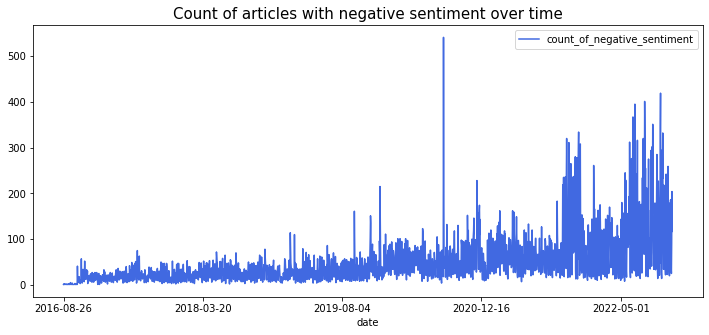

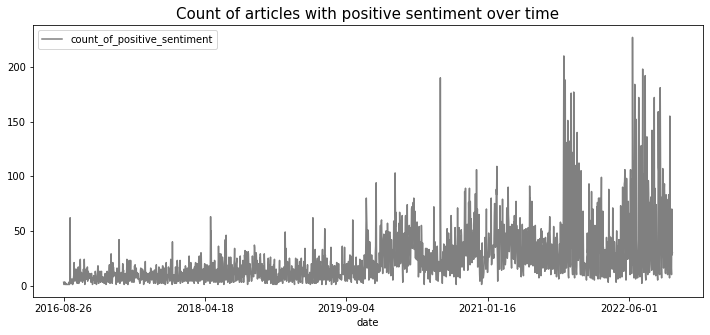

In [7]:
plt.rcParams["figure.figsize"] = [12,5]
df_count_neg.plot(color = 'royalblue').set_title("Count of articles with negative sentiment over time", fontsize = 15)
df_count_pos.plot(color = "gray").set_title("Count of articles with positive sentiment over time", fontsize = 15)

In [10]:
# positive: date with max count
df_count_pos.sort_values(by = "count_of_positive_sentiment", ascending= False).head()

,count_of_positive_sentiment
date,
2022-06-14,227
2021-10-14,210
2022-07-20,198
2022-07-29,192
2020-08-02,190


In [12]:
# negative: date with max count
df_count_neg.sort_values(by = "count_of_negative_sentiment", ascending= False).head()

,count_of_negative_sentiment
date,
2020-08-02,541
2022-09-21,419
2022-07-26,401
2022-06-21,395
2022-06-14,367


In [19]:
import nltk as nltk
import nltk.corpus 
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [17]:
temp = df_neg[df_neg["date"]=="2020-08-02"][["clean_text"]]

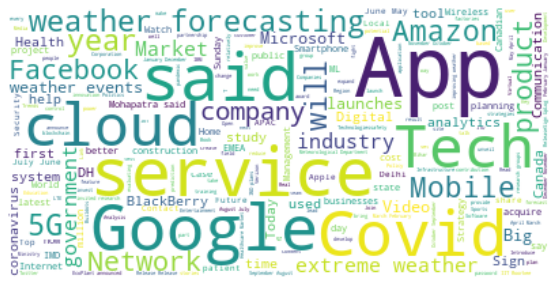

In [23]:
text = " ".join(entities for entities in temp.clean_text)
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['AI', 'ai','artificial', 'intelligence', 'artificial intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'data', 'DATA SCIENCE',
                  'science', 'wfmz', 'venturebeat', 'machine', 'learning', 'using', 'use', 'technology', 
                  'global','new', 'solution', 'startup', 'platform', 'US', 'U', 'S', 'market size','newsbreak', 'china', 'daily', 'mail', 'news',
                 'online', 'india', 'report', 'business', 'North', 'Chief', 'America'])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [35]:
temp = df_pos[(df_pos["date"]=="2022-06-14")|(df_pos["date"]=="2021-10-14")|(df_pos["date"]=="2022-07-20")|(df_pos["date"]=="2022-08-2")|(df_pos["date"]=="2022-07-29")][["clean_text"]]

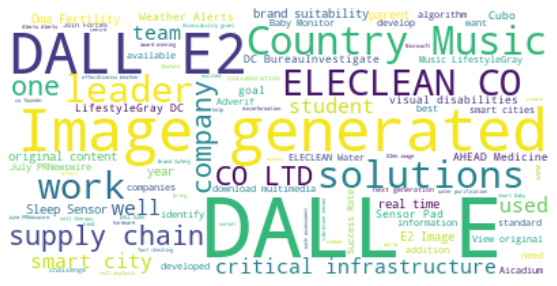

In [36]:
text = " ".join(entities for entities in temp.clean_text)
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['AI', 'ai','artificial', 'intelligence', 'artificial intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'Data Science', 'data science', 'data', 'DATA SCIENCE',
                  'science', 'wfmz', 'venturebeat', 'machine', 'learning', 'using', 'use', 'technology', 
                  'global','new', 'solution', 'startup', 'platform', 'US', 'U', 'S', 'market size','newsbreak', 'china', 'daily', 'mail', 'news',
                 'online', 'india', 'report', 'business'])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()